In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

---
# Load files and Functions

## Load files

In [2]:
#read bridges and info about LRP data
lrp=pd.read_csv('../data/raw/Roads_InfoAboutEachLRP.csv', low_memory=False)
df_bridge = pd.read_excel("../data/raw/BMMS_overview.xlsx")
road=pd.read_csv('../data/processed/_roads.tsv', sep='\t', low_memory=False) #take the already proceesd road data as input

In [3]:
# ---- Load wide file (like you already did) ----
road = road.copy()

# Make sure first column is named 'road'
road = road.rename(columns={road.columns[0]: "road"})

tidy_rows = []

for _, row in road.iterrows():
    road_name = row["road"]
    
    # Everything after first column are repeating triples
    values = row.iloc[1:].values
    
    # Loop through in steps of 3 (lrp, lat, lon)
    for i in range(0, len(values), 3):
        try:
            lrp = values[i]
            lat = values[i+1]
            lon = values[i+2]
        except IndexError:
            break  # incomplete triple at end
        
        # Skip completely empty triples
        if pd.isna(lrp) and pd.isna(lat) and pd.isna(lon):
            continue
        
        tidy_rows.append({
            "road": road_name,
            "lrp": lrp,
            "lat": pd.to_numeric(lat, errors="coerce"),
            "lon": pd.to_numeric(lon, errors="coerce")
        })

# Create tidy dataframe
tidy = pd.DataFrame(tidy_rows)

# Drop rows where everything is missing
tidy = tidy.dropna(subset=["lrp", "lat", "lon"], how="all")

# Reset index
tidy = tidy.reset_index(drop=True)

print("Tidy shape:", tidy.shape)

Tidy shape: (51861, 4)


## Duplicate values algorithm

In [4]:
def check_duplicates(df, cols=None, excl=None):
    """
    Flags duplicate rows and returns dataframe + log dataframe.

    Parameters
    ----------
    df : pandas.DataFrame
    cols : list or None
        Columns to check subset duplicates on (optional)
    excl : list or None
        Columns to ignore during duplicate checking

    Returns
    -------
    df_out : dataframe with 'duplicate' column
    log_df : dataframe containing duplicated rows with reason
    """

    df_out = df.copy()
    #df_out["duplicate"] = False

    log_parts = []

    # columns to exclude
    excl = excl or []

    # ---------- 1) FULL ROW DUPLICATES ----------
    full_cols = [c for c in df_out.columns if c not in excl]

    dup_full_mask = df_out.duplicated(subset=full_cols, keep=False)
    #df_out.loc[dup_full_mask, "duplicate"] = True

    if dup_full_mask.any():
        log_full = df_out.loc[dup_full_mask].copy()
        log_full["duplicate_reason"] = f"all column duplicate"
        log_parts.append(log_full)
    df_out=df_out.drop_duplicates(subset=full_cols)

    # ---------- 2) SUBSET DUPLICATES ----------
    if cols:
        subset_cols = [c for c in cols if c not in excl]

        if len(subset_cols) > 0:
            dup_subset_mask = df_out.duplicated(subset=subset_cols, keep=False)
            #df_out.loc[dup_subset_mask, "duplicate"] = True

            if dup_subset_mask.any():
                log_subset = df_out.loc[dup_subset_mask].copy()
                log_subset["duplicate_reason"] = f"duplicate on:{subset_cols}"
                log_parts.append(log_subset)
        df_out=df_out.drop_duplicates(subset=subset_cols)

    # ---------- COMBINE LOG ----------
    if log_parts:
        log_df = pd.concat(log_parts).drop_duplicates().reset_index(drop=True)
    else:
        log_df = pd.DataFrame(columns=list(df_out.columns) + ["duplicate_reason"])

    return df_out, log_df

## Fixing roads function

In [5]:
import re

_lrp_re = re.compile(r"^LRP(\d+)([A-Za-z]*)$")

def lrp_sort_key(lrp: str):
    """
    Returns a tuple used for sorting LRPs in chainage-like order:
    LRPS, LRPSa, LRPSb ... first
    then LRP001, LRP001a, LRP001b ...
    then ...
    LRPE last
    Unknown formats go to the end (but before LRPE).
    """
    if pd.isna(lrp):
        return (10**9, "zz")  # push NA to end
    
    s = str(lrp).strip()

    # Start markers
    if s == "LRPS":
        return (-1, "")
    if s.startswith("LRPS") and len(s) > 4:
        # LRPSa, LRPSb ...
        return (-1, s[4:])

    # End marker
    if s == "LRPE":
        return (10**12, "zzzz")

    # Standard LRP###suffix
    m = _lrp_re.match(s)
    if m:
        num = int(m.group(1))
        suf = m.group(2) or ""
        return (num, suf)

    # fallback for weird labels
    return (10**9, s)

def sort_road_by_lrp(df_points):
    df = df_points.copy()
    df["_k"] = df["lrp"].apply(lrp_sort_key)
    df = df.sort_values("_k").drop(columns="_k").reset_index(drop=True)
    return df


In [6]:
# ----------------------------
# Distance
# ----------------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def compute_segments(df):
    """Adds next_lat/next_lon + seg distance. Expects ordered points."""
    out = df.copy()
    out["next_lat"] = out["lat"].shift(-1)
    out["next_lon"] = out["lon"].shift(-1)
    out["seg"] = haversine(out["lat"], out["lon"], out["next_lat"], out["next_lon"])
    return out

# ----------------------------
# Stage A: Block repair
# ----------------------------
def block_repair(df_points, K=15, min_run_len=2):
    """
    Detect consecutive jump segments and linearly interpolate across the block.
    df_points: columns ['lrp','lat','lon'] in correct order.
    Returns: fixed_df, actions(list)
    """
    df = compute_segments(df_points).reset_index(drop=True)
    median_seg = df["seg"].median()
    thr = K * median_seg

    df["is_jump_seg"] = df["seg"] > thr
    df["run_id"] = (df["is_jump_seg"] != df["is_jump_seg"].shift()).cumsum()

    jump_runs = df[df["is_jump_seg"]].groupby("run_id").indices
    fixed = df_points.copy().reset_index(drop=True)
    actions = []

    for run_id, idxs in jump_runs.items():
        idxs = list(idxs)
        if len(idxs) < min_run_len:
            continue

        # segments idxs[0]..idxs[-1] correspond to points [left_idx .. right_idx]
        left_idx = idxs[0]
        right_idx = idxs[-1] + 1

        # bounds + must have endpoints
        if left_idx <= 0 or right_idx >= len(fixed):
            continue
        if fixed.loc[left_idx, ["lat","lon"]].isna().any() or fixed.loc[right_idx, ["lat","lon"]].isna().any():
            continue

        L = right_idx - left_idx
        for k in range(1, L):
            new_lat = fixed.loc[left_idx, "lat"] + (fixed.loc[right_idx, "lat"] - fixed.loc[left_idx, "lat"]) * (k / L)
            new_lon = fixed.loc[left_idx, "lon"] + (fixed.loc[right_idx, "lon"] - fixed.loc[left_idx, "lon"]) * (k / L)

            old_lat, old_lon = fixed.loc[left_idx+k, "lat"], fixed.loc[left_idx+k, "lon"]
            fixed.loc[left_idx+k, "lat"] = new_lat
            fixed.loc[left_idx+k, "lon"] = new_lon

            actions.append({
                "idx": left_idx+k,
                "lrp": fixed.loc[left_idx+k, "lrp"],
                "action": "block_interp",
                "old_lat": old_lat, "old_lon": old_lon,
                "new_lat": new_lat, "new_lon": new_lon,
                "run_len": len(idxs),
                "thr_km": thr
            })

    return fixed, actions

# ----------------------------
# Stage B: Smart single-segment repair
# ----------------------------
def smart_single_seg_repair(df_points, K=15, max_iters=5):
    """
    Fix remaining isolated jump segments by deciding whether to adjust point i or i+1.
    df_points: columns ['lrp','lat','lon'] ordered.
    Returns: fixed_df, actions(list)
    """
    df = df_points.copy().reset_index(drop=True)
    actions = []

    for _ in range(max_iters):
        tmp = compute_segments(df)
        med = tmp["seg"].median()
        thr = K * med

        bad_idxs = tmp.index[tmp["seg"] > thr].tolist()
        if not bad_idxs:
            break

        for i in bad_idxs:
            # need neighborhood i-1, i, i+1, i+2
            if i <= 0 or i >= len(df)-2:
                continue

            p_im1 = (df.loc[i-1, "lat"], df.loc[i-1, "lon"])
            p_i   = (df.loc[i,   "lat"], df.loc[i,   "lon"])
            p_ip1 = (df.loc[i+1, "lat"], df.loc[i+1, "lon"])
            p_ip2 = (df.loc[i+2, "lat"], df.loc[i+2, "lon"])

            if any(pd.isna([*p_im1, *p_i, *p_ip1, *p_ip2])):
                continue

            cur = (
                haversine(p_im1[0], p_im1[1], p_i[0], p_i[1]) +
                haversine(p_i[0], p_i[1], p_ip1[0], p_ip1[1]) +
                haversine(p_ip1[0], p_ip1[1], p_ip2[0], p_ip2[1])
            )

            # Fix A: adjust point i
            fixA = ((p_im1[0] + p_ip1[0]) / 2, (p_im1[1] + p_ip1[1]) / 2)
            scoreA = (
                haversine(p_im1[0], p_im1[1], fixA[0], fixA[1]) +
                haversine(fixA[0], fixA[1], p_ip1[0], p_ip1[1]) +
                haversine(p_ip1[0], p_ip1[1], p_ip2[0], p_ip2[1])
            )

            # Fix B: adjust point i+1
            fixB = ((p_i[0] + p_ip2[0]) / 2, (p_i[1] + p_ip2[1]) / 2)
            scoreB = (
                haversine(p_im1[0], p_im1[1], p_i[0], p_i[1]) +
                haversine(p_i[0], p_i[1], fixB[0], fixB[1]) +
                haversine(fixB[0], fixB[1], p_ip2[0], p_ip2[1])
            )

            best = min(cur, scoreA, scoreB)
            if best >= cur:
                continue

            if best == scoreA:
                old_lat, old_lon = df.loc[i, "lat"], df.loc[i, "lon"]
                df.loc[i, "lat"], df.loc[i, "lon"] = fixA
                actions.append({
                    "idx": i,
                    "lrp": df.loc[i, "lrp"],
                    "action": "smart_fix_i_mid(im1,ip1)",
                    "old_lat": old_lat, "old_lon": old_lon,
                    "new_lat": fixA[0], "new_lon": fixA[1],
                    "thr_km": thr
                })
            else:
                old_lat, old_lon = df.loc[i+1, "lat"], df.loc[i+1, "lon"]
                df.loc[i+1, "lat"], df.loc[i+1, "lon"] = fixB
                actions.append({
                    "idx": i+1,
                    "lrp": df.loc[i+1, "lrp"],
                    "action": "smart_fix_i+1_mid(i,ip2)",
                    "old_lat": old_lat, "old_lon": old_lon,
                    "new_lat": fixB[0], "new_lon": fixB[1],
                    "thr_km": thr
                })

    return df, actions

# ----------------------------
# Full repair for one road
# ----------------------------
def repair_road_points(df_road_points, K=15, min_run_len=2):
    # ✅ NEW: sort by LRP before any distance work
    df_road_points = sort_road_by_lrp(df_road_points)

    before = compute_segments(df_road_points)
    before_med = before["seg"].median()
    before_thr = K * before_med
    before_jumps = int((before["seg"] > before_thr).sum())
    before_max = float(before["seg"].max())

    fixedA, actionsA = block_repair(df_road_points, K=K, min_run_len=min_run_len)
    fixedB, actionsB = smart_single_seg_repair(fixedA, K=K)

    after = compute_segments(fixedB)
    after_med = after["seg"].median()
    after_thr = K * after_med
    after_jumps = int((after["seg"] > after_thr).sum())
    after_max = float(after["seg"].max())

    metrics = {
        "median_seg_before": before_med,
        "thr_before": before_thr,
        "jumps_before": before_jumps,
        "max_seg_before": before_max,
        "median_seg_after": after_med,
        "thr_after": after_thr,
        "jumps_after": after_jumps,
        "max_seg_after": after_max,
        "actions_block": len(actionsA),
        "actions_smart": len(actionsB),
        "actions_total": len(actionsA) + len(actionsB),
    }

    actions = actionsA + actionsB
    return fixedB, actions, metrics


# ----------------------------
# Plot before/after for a road
# ----------------------------
def plot_road_before_after(tidy_df, road_name, fixed_df=None, K=15, title_suffix=""):
    """
    tidy_df: full tidy dataframe (road, lrp, lat, lon) in original order
    fixed_df: optional fixed points (lrp, lat, lon) for the road; if None we repair on the fly.
    """
    road_pts = tidy_df[tidy_df["road"] == road_name][["lrp","lat","lon"]].copy().reset_index(drop=True)

    if fixed_df is None:
        fixed_df, _, metrics = repair_road_points(road_pts, K=K)
    else:
        metrics = None

    # plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    axes[0].plot(road_pts["lon"], road_pts["lat"], marker="o", markersize=2, linewidth=1)
    axes[0].set_title(f"{road_name} BEFORE {title_suffix}")
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")

    axes[1].plot(fixed_df["lon"], fixed_df["lat"], marker="o", markersize=2, linewidth=1)
    axes[1].set_title(f"{road_name} AFTER {title_suffix}")
    axes[1].set_xlabel("Longitude")
    axes[1].set_ylabel("Latitude")

    plt.tight_layout()
    plt.show()

    if metrics is not None:
        print(metrics)
    

# ----------------------------
# Repair ALL roads
# ----------------------------
def repair_all_roads(tidy_df, K=15, min_run_len=2, max_roads=None):
    """
    tidy_df: columns ['road','lrp','lat','lon'] in original order
    Returns: cleaned_tidy_df, actions_df, metrics_df
    """
    cleaned_parts = []
    all_actions = []
    all_metrics = []

    roads = tidy_df["road"].dropna().unique().tolist()
    if max_roads is not None:
        roads = roads[:max_roads]

    for r in roads:
        road_pts = tidy_df[tidy_df["road"] == r].copy().reset_index(drop=True)
        fixed_pts, actions, metrics = repair_road_points(road_pts, K=K, min_run_len=min_run_len)

        fixed_out = fixed_pts.copy()
        #fixed_out.insert(0, "road", r)
        cleaned_parts.append(fixed_out)

        for a in actions:
            a["road"] = r
        all_actions.extend(actions)

        metrics["road"] = r
        all_metrics.append(metrics)

    cleaned = pd.concat(cleaned_parts, ignore_index=True)
    actions_df = pd.DataFrame(all_actions)
    metrics_df = pd.DataFrame(all_metrics)

    return cleaned, actions_df, metrics_df


In [7]:
def plot_road_before_after_2(tidy_df, road_name, fixed_df=None, K=15, title_suffix=""):
    """
    tidy_df: full tidy dataframe (road, lrp, lat, lon) in original order
    fixed_df: optional fixed points (lrp, lat, lon) for the road; if None we repair on the fly.
    """
    road_pts = tidy_df[tidy_df["road"] == road_name].copy().reset_index(drop=True)

    if fixed_df is None:
        fixed_df, _, metrics = repair_road_points(road_pts, K=K)
    else:
        metrics = None

    fixed_df2, _, metrics = repair_road_points(fixed_df, K=K)
    
    # plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    axes[0].plot(road_pts["lon"], road_pts["lat"], marker="o", markersize=2, linewidth=1)
    axes[0].set_title(f"{road_name} BEFORE {title_suffix}")
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")

    axes[1].plot(fixed_df2["lon"], fixed_df2["lat"], marker="o", markersize=2, linewidth=1)
    axes[1].set_title(f"{road_name} AFTER {title_suffix}")
    axes[1].set_xlabel("Longitude")
    axes[1].set_ylabel("Latitude")

    plt.tight_layout()
    plt.show()

    if metrics is not None:
        print(metrics)
    


In [8]:
def plot_all_roads_before_after(tidy_df, cleaned_df):
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # BEFORE
    axes[0].scatter(
        tidy_df["lon"], tidy_df["lat"],
        s=1, alpha=0.5
    )
    axes[0].set_title("All Roads BEFORE Repair")
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")

    # AFTER
    axes[1].scatter(
        cleaned_df["lon"], cleaned_df["lat"],
        s=1, alpha=0.5
    )
    axes[1].set_title("All Roads AFTER Repair")
    axes[1].set_xlabel("Longitude")
    axes[1].set_ylabel("Latitude")

    plt.tight_layout()
    plt.show()


## Chainage monotony function

In [9]:
#Function to check monotony in datasets

def check_chainage_monotony(df):
    # convert the chainage column to numeric values, if value cannot be converted it becomes NaN
    df["chainage"] = pd.to_numeric(df["chainage"], errors="coerce")
    # create empty list to store True or False values indicating whether there's monotony within each road group
    report = []
    # loop through each group of rows grouped by "road"
    for road, group in df.groupby("road"):
        # reset index inside each group so iteration start from 0 (and drop old index column)
        group = group.reset_index(drop=True)
        # variable to keep track of previous chainage value
        prev_chainage = None
        # iterate through each row in the grouped DataFrame
        for i, row in group.iterrows():
            current_chainage = row["chainage"]

            # it it's the first row in the group, it will automatically be marked as monotone (True)
            if prev_chainage is None:
                report.append(True)
            else:
                # Check if current chainage is greater than or equal to the previous one
                report.append(current_chainage >= prev_chainage)
            # update chainage for next iteration
            prev_chainage = current_chainage

    # add the report as new column to original dataframe
    df["monotone"] = report

    not_monotone = df.groupby("road")["monotone"].all().eq(False).sum()
    # print results
    if not_monotone == 0:
        print("All roads in the dataset have chainage monotony")
    else:
        print(not_monotone, "roads break chainage monotony")
        road_monotone = df.groupby("road")["monotone"].all()
        broken_roads = road_monotone[road_monotone ==False].index
        print("Roads that break monotony:", broken_roads)

In [10]:
# Observing the dataset, the roads seem to be all over the place
# N1 in initial rows but also afterwards
# Here's a function to group and sort them in order

def fix_chainage_monotony(df): 
    df = df.copy()
    # group frist by road and sort each road by chainage
    df_sorted = df.sort_values(by=["road", "chainage"]).reset_index(drop=True)
    return df_sorted

## Inverted lon lat function

In [11]:
min_lat, max_lat = 20.86382, 26.33338
min_lon, max_lon = 88.15638, 92.30153

def detect_bridges_inverted_coordinates(df1, lat_col='lat', lon_col='lon', road_col='road', lrp_col='LRPName'):
    df=df1.copy()
    # Create flags for inverted coordinates and far-out coordinates
    df['inverted_coords'] = (
        (df[lat_col] >= min_lon) & (df[lat_col] <= max_lon) &  # Latitude in longitude range
        (df[lon_col] >= min_lat) & (df[lon_col] <= max_lat)    # Longitude in latitude range
    )
    
    return df

In [12]:
def swap_lat_lon(df1):
    """
    Swap lat/lon only where inverted_coords == True
    and set the flag to False after correction

    Returns:
        corrected dataframe
        log dataframe
    """

    df = df1.copy()

    mask = df["inverted_coords"] == True

    # ---- CREATE LOG BEFORE CHANGING ----
    log_df = pd.DataFrame({
        "road": df.loc[mask, "road"],
        "LRPName": df.loc[mask, "LRPName"],
        "old_lat": df.loc[mask, "lat"],
        "old_lon": df.loc[mask, "lon"],
        "new_lat": df.loc[mask, "lon"],
        "new_lon": df.loc[mask, "lat"],
    }).reset_index(drop=True)

    # ---- SWAP COORDINATES ----
    df.loc[mask, ["lat", "lon"]] = df.loc[mask, ["lon", "lat"]].values

    # ---- TURN OFF FLAG ----
    df.loc[mask, "inverted_coords"] = False

    return df, log_df

## Out of boundary box function

In [13]:
def detect_bridges_out_coordinates(df1, lat_col='lat', lon_col='lon', road_col='road', lrp_col='LRPName'):
    df=df1.copy()
        
    df['far_out_coords'] = ( 
        ((df[lat_col] < min_lat) | (df[lat_col] > max_lat)) &  # Latitude outside range
        ((df[lon_col] < min_lon) | (df[lon_col] > max_lon))    # Longitude outside range
    )
    
    return df

In [14]:
def fix_far_out_coords(b, lrp):
    """
    Correct coordinates in dataframe b using reference dataframe lrp.
    Only rows with far_out_coords == True are processed.

    Returns:
        corrected dataframe
        log dataframe of applied changes
    """

    b = b.copy()

    # rows to process
    mask = b["far_out_coords"] == True
    b_sub = b.loc[mask]

    # merge subset with reference
    merged = b_sub.merge(
        lrp[["road", "lrp", "lat", "lon"]],
        left_on=["road", "LRPName"],
        right_on=["road", "lrp"],
        how="left",
        suffixes=("", "_ref")
    )

    # rows where match exists
    matched = merged["lat_ref"].notna()

    # --- CREATE LOG ---
    log_df = pd.DataFrame({
        "road": merged.loc[matched, "road"],
        "LRPName": merged.loc[matched, "LRPName"],
        "old_lat": merged.loc[matched, "lat"],
        "old_lon": merged.loc[matched, "lon"],
        "new_lat": merged.loc[matched, "lat_ref"],
        "new_lon": merged.loc[matched, "lon_ref"],
    }).reset_index(drop=True)

    # --- UPDATE ORIGINAL DATAFRAME ---
    idx_to_update = b_sub.index[matched]

    b.loc[idx_to_update, "lat"] = merged.loc[matched, "lat_ref"].values
    b.loc[idx_to_update, "lon"] = merged.loc[matched, "lon_ref"].values
    b.loc[idx_to_update, "far_out_coords"] = False

    return b, log_df

## NaN Values lookup function

In [15]:
def drop_redundant_nan_coords(df):
    """
    Remove rows with NaN lat/lon only when a valid coordinate exists
    for the same (road, LRPName).

    Returns:
        cleaned dataframe
        removed rows log
    """

    df = df.copy()

    # rows with missing coords
    nan_mask = df["lat"].isna() | df["lon"].isna()
    df_nan = df[nan_mask].copy()

    # keep original index
    df_nan["_orig_index"] = df_nan.index

    # rows with valid coords
    df_valid_keys = df.loc[~nan_mask, ["road", "LRPName"]].drop_duplicates()

    # find NaN rows that have a valid twin
    matched = df_nan.merge(df_valid_keys, on=["road", "LRPName"], how="inner")

    drop_idx = matched["_orig_index"]

    # log removed rows
    removed_log = df.loc[drop_idx].copy()

    # drop only those rows
    df_cleaned = df.drop(index=drop_idx)

    return df_cleaned.reset_index(drop=True), removed_log.reset_index(drop=True)

In [16]:
def fill_nan_coords(df, lrp):
    """
    Fill missing lat/lon in df using reference dataframe lrp.

    Conditions:
    - Only rows where lat OR lon is NaN are processed
    - Match on df.road == lrp.road AND df.LRPName == lrp.lrp
    - Only update when match exists
    - Returns corrected dataframe and log dataframe
    """

    df = df.copy()

    # rows needing coordinates
    mask = df["lat"].isna() | df["lon"].isna()
    df_sub = df.loc[mask]

    # merge with reference
    merged = df_sub.merge(
        lrp[["road", "lrp", "lat", "lon"]],
        left_on=["road", "LRPName"],
        right_on=["road", "lrp"],
        how="left",
        suffixes=("", "_ref")
    )

    # matched rows (have reference coordinates)
    matched = merged["lat_ref"].notna() & merged["lon_ref"].notna()

    # ---- LOG ----
    log_df = pd.DataFrame({
        "road": merged.loc[matched, "road"],
        "LRPName": merged.loc[matched, "LRPName"],
        "new_lat": merged.loc[matched, "lat_ref"],
        "new_lon": merged.loc[matched, "lon_ref"],
    }).reset_index(drop=True)

    # ---- UPDATE ORIGINAL DF ----
    idx_to_update = df_sub.index[matched]

    df.loc[idx_to_update, "lat"] = merged.loc[matched, "lat_ref"].values
    df.loc[idx_to_update, "lon"] = merged.loc[matched, "lon_ref"].values

    return df, log_df

---
# Duplicate Values

In [17]:
excl=['structureNr']
cols=['road','chainage','condition','LRPName','lat','lon','name']

In [18]:
pd.set_option('display.max_columns', None)

In [61]:
df_bridges,log_dup2= check_duplicates(df_bridge, cols=cols, excl=excl)
print('Number of rows with duplicated values: ' + str(log_dup2.shape[0]))
print('Number of rows with total duplicated values: ' + str(log_dup2[(log_dup2['duplicate_reason']=="all column duplicate")].shape[0]))
print('Number of rows with duplicated values on selected column: ' + str(log_dup2[~(log_dup2['duplicate_reason']=="all column duplicate")].shape[0]))#duplicate on all column and only subset column, subject to remove

Number of rows with duplicated values: 18
Number of rows with total duplicated values: 14
Number of rows with duplicated values on selected column: 4


In [67]:
log_dup2[['road','LRPName']] #duplicated values, keep only the first occurence

,road,LRPName
0,R556,LRP015a
1,R556,LRP015a
2,Z5509,LRP026a
3,Z5509,LRP026a
4,N603,LRPSc
5,N603,LRPSc
6,Z8052,LRP009c
7,Z8052,LRP009c
8,N5,LRP388b
9,N5,LRP388b


---
# Chainage Monotony

In [24]:
df_roads = pd.read_csv("../data/raw/Roads_InfoAboutEachLRP.csv")

check_chainage_monotony(df_roads)

All roads in the dataset have chainage monotony


In [25]:
check_chainage_monotony(df_bridges)

# the output is only one road with broken montony R750, 
# but seems this doesn't have coordinates nor much data, likely to be road
# in conclusion, both datasets 

505 roads break chainage monotony
Roads that break monotony: Index(['N1', 'N102', 'N104', 'N105', 'N106', 'N107', 'N108', 'N110', 'N2',
       'N204',
       ...
       'Z8713', 'Z8717', 'Z8803', 'Z8806', 'Z8810', 'Z8905', 'Z8909', 'Z8910',
       'Z8913', 'Z8915'],
      dtype='object', name='road', length=505)


In [26]:
df_sorted_bridges = fix_chainage_monotony(df_bridges)
check_chainage_monotony(df_sorted_bridges)

1 roads break chainage monotony
Roads that break monotony: Index(['R750'], dtype='object', name='road')


In [27]:
df_sorted_bridges[(df_sorted_bridges['monotone']==False)]

,road,km,type,LRPName,name,length,condition,structureNr,roadName,chainage,width,constructionYear,spans,zone,circle,division,sub-division,lat,lon,EstimatedLoc,monotone
7691,R750,NaN,RCC Girder Bridge,LRP006b,Daitala Bridge,41.5,A,118833,Jessore-Narail Road,NaN,NaN,NaN,NaN,Khulna,Jessore,Jessore,Jessore-2,NaN,NaN,bcs1,False


In [28]:
df_sorted_bridges[(df_sorted_bridges['road']=='R750') & (df_sorted_bridges['LRPName']=='LRP006b')]

,road,km,type,LRPName,name,length,condition,structureNr,roadName,chainage,width,constructionYear,spans,zone,circle,division,sub-division,lat,lon,EstimatedLoc,monotone
7663,R750,6.135,RCC Girder Bridge,LRP006b,Daitala Bridge,41.6,C,104032,Jessore-Narail Road,6.135,7.28,1976.0,3.0,Khulna,Jessore,Jessore,Jessore-2,23.168056,89.279722,bcs1,True
7691,R750,NaN,RCC Girder Bridge,LRP006b,Daitala Bridge,41.5,A,118833,Jessore-Narail Road,NaN,NaN,NaN,NaN,Khulna,Jessore,Jessore,Jessore-2,NaN,NaN,bcs1,False


Chainage breaks because one entry in the road has a NaN value in the chainage column 

Since this row has the same LRP, name and length as another entry, we assume it refers to the same bridge

We drop the row with NaN value in chainage

In [29]:
df_sorted_bridges = df_sorted_bridges.drop(df_sorted_bridges[(df_sorted_bridges['chainage'].isna()) & (df_sorted_bridges["road"] == "R750")].index)
check_chainage_monotony(df_sorted_bridges)

All roads in the dataset have chainage monotony


In [31]:
df_sorted_bridges.to_excel("../data/processed/BMMS_cleaned_monotony.xlsx")

---
# Lattitude and Longitude Issues

In [32]:
# Call the function to see the swapped bridges in data
a = detect_bridges_inverted_coordinates(df_sorted_bridges)
#a[(a['inverted_coords']==True)]

In [33]:
df_brigdes_2,log_swap=swap_lat_lon(a)

In [34]:
log_swap

,road,LRPName,old_lat,old_lon,new_lat,new_lon
0,R241,LRP026a,91.544194,24.773694,24.773694,91.544194
1,R241,LRP027a,91.542389,24.786833,24.786833,91.542389
2,R241,LRP028a,91.541778,24.790944,24.790944,91.541778
3,R241,LRP028c,91.542083,24.796694,24.796694,91.542083
4,R241,LRP029a,91.543889,24.805111,24.805111,91.543889
5,R241,LRP031a,91.538722,24.816556,24.816556,91.538722
6,R241,LRP032a,91.534361,24.823833,24.823833,91.534361
7,R241,LRP032b,91.530556,24.828056,24.828056,91.530556
8,R241,LRP033a,91.527917,24.830944,24.830944,91.527917
9,R241,LRP033b,91.524083,24.835222,24.835222,91.524083


In [35]:
print (str(log_swap.shape[0]) + " lrps swapped")

15 lrps swapped


---
# Out of boundary issues

In [36]:
b=detect_bridges_out_coordinates(df_brigdes_2)

In [37]:
b[(b['far_out_coords']==True)].shape[0] #number of out of bound LRPs

33

In [38]:
df_brigdes_3,log_outofbound=fix_far_out_coords(b, tidy) #try to get the far out from the already corrected road dataframe
log_outofbound

,road,LRPName,old_lat,old_lon,new_lat,new_lon
0,Z1099,LRP005a,20.670667,92.305528,20.820638,92.305500
1,Z1099,LRP005b,20.815917,92.307917,20.816000,92.307917
2,Z1099,LRP006a,20.814500,92.308667,20.812556,92.309917
3,Z1099,LRP006b,20.812556,92.309917,20.809917,92.311361
4,Z1099,LRP007a,20.803944,92.313611,20.803833,92.313861
5,Z1099,LRP007c,20.801972,92.314583,20.798333,92.315806
6,Z1099,LRP008a,20.798306,92.315611,20.796055,92.316749
7,Z1099,LRP008b,20.795639,92.316972,20.790805,92.318110


8 out of bound values patched

In [39]:
df_brigdes_3[(df_brigdes_3["far_out_coords"]==True)].shape[0] #number of uncorrected data (including lat lon 0.0)

25

---
# NaN Values issue

In [40]:
df_brigdes_3.columns

Index(['road', 'km', 'type', 'LRPName', 'name', 'length', 'condition',
       'structureNr', 'roadName', 'chainage', 'width', 'constructionYear',
       'spans', 'zone', 'circle', 'division', 'sub-division', 'lat', 'lon',
       'EstimatedLoc', 'monotone', 'inverted_coords', 'far_out_coords'],
      dtype='object')

In [41]:
cleaned_df, removed_nan_rows = drop_redundant_nan_coords(df_brigdes_3)

cleaned_df.shape

(21308, 23)

In [42]:
removed_nan_rows.shape

(89, 23)

In [43]:
removed_nan_rows.head(2)

,road,km,type,LRPName,name,length,condition,structureNr,roadName,chainage,width,constructionYear,spans,zone,circle,division,sub-division,lat,lon,EstimatedLoc,monotone,inverted_coords,far_out_coords
0,N208,58.496,Steel Beam & RCC Slab,LRP058b,Keen Bridge,358.0,D,120682,Moulvibazar-Rajnagar-Fenchuganj-Sylhet Road,58.496,NaN,NaN,NaN,Sylhet,Sylhet,Sylhet,Biswanath,NaN,NaN,error,True,False,False
1,R505,7.685,RCC Girder Bridge,LRP007a,Chakrabarti Bridge,34.2,B,120157,Nabinagar-EPZ-Kaliakoir (Chandra) Road,7.685,NaN,NaN,NaN,Dhaka,Dhaka,Manikganj,Nayarhat,NaN,NaN,bcs1,True,False,False


In [44]:
df_brigdes_4,log_NaN=fill_nan_coords(cleaned_df, tidy) #try to get the nan from the already corrected road dataframe
log_NaN

,road,LRPName,new_lat,new_lon


no information on the remaining NaN that can be found in the other dataset, left as to not remove bridges information and allow for possible additional reference to be available

---
# Bridge Placement Adjustment

In [45]:
df_bridges_4=df_brigdes_4.rename(columns={'LRPName': 'lrp'})
df_bridges_4.head()

,road,km,type,lrp,name,length,condition,structureNr,roadName,chainage,width,constructionYear,spans,zone,circle,division,sub-division,lat,lon,EstimatedLoc,monotone,inverted_coords,far_out_coords
0,N1,1.800,Box Culvert,LRP001a,.,11.30,A,117861,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,1.800,19.50,2005.0,2.0,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.702889,90.450389,bcs1,True,False,False
1,N1,4.925,Box Culvert,LRP004b,.,6.60,A,117862,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,4.925,35.40,2006.0,1.0,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.693611,90.478833,bcs1,True,False,False
2,N1,8.976,PC Girder Bridge,LRP008b,Kanch pur Bridge.,394.23,A,119889,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,8.976,NaN,NaN,NaN,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.704583,90.518833,road_precise,True,False,False
3,N1,8.976,PC Girder Bridge,LRP008b,KANCHPUR PC GIRDER BRIDGE,397.00,C,101102,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,8.976,14.65,1986.0,8.0,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.702083,90.515917,bcs1,True,False,False
4,N1,10.543,Box Culvert,LRP010a,KATCHPUR BOX CULVERT,8.00,B,101106,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,10.543,21.70,1987.0,2.0,Dhaka,Dhaka,Narayanganj,Vitikandi,23.702056,90.528194,bcs1,True,False,False


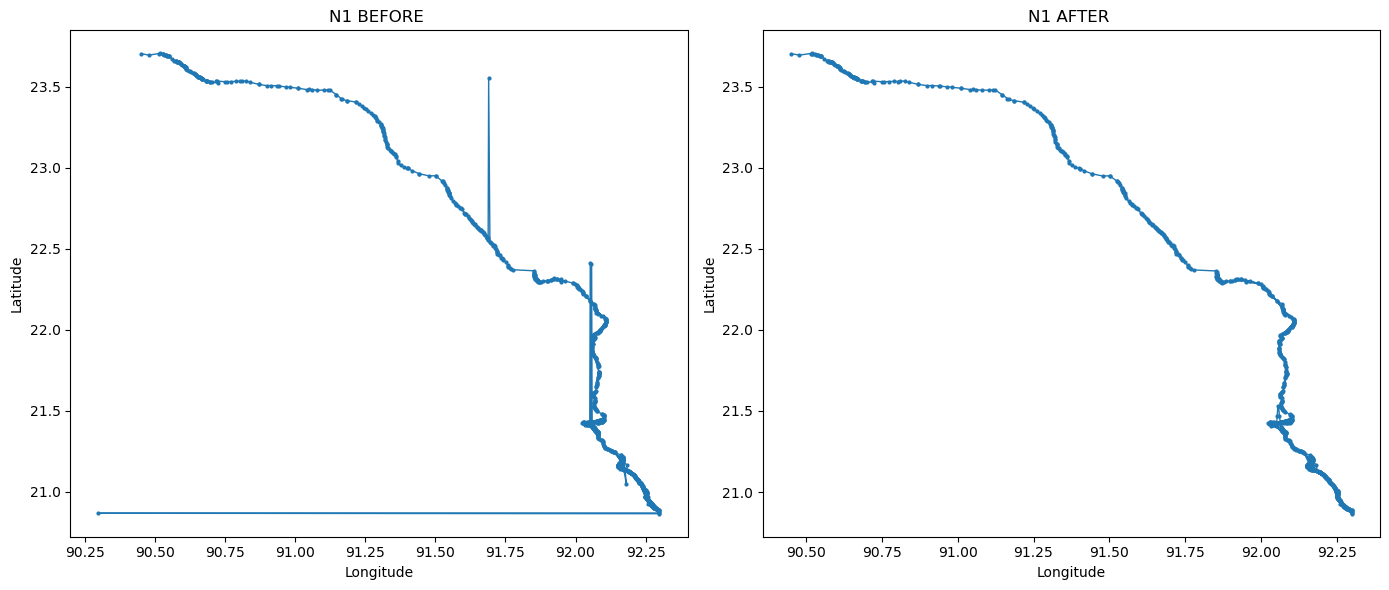

{'median_seg_before': 0.6585636184880912, 'thr_before': 9.878454277321367, 'jumps_before': 12, 'max_seg_before': 207.80079611309426, 'median_seg_after': 0.6457569364309788, 'thr_after': 9.68635404646468, 'jumps_after': 0, 'max_seg_after': 9.585754222687266, 'actions_block': 4, 'actions_smart': 18, 'actions_total': 22}


In [46]:
plot_road_before_after(df_bridges_4, "N1", K=15)

In [47]:
cleaned_tidy, actions_df, metrics_df = repair_all_roads(df_bridges_4, K=15, min_run_len=2, max_roads=None)
print("Cleaned tidy shape:", cleaned_tidy.shape)
#plot_all_roads_before_after(df_bridges_4, cleaned_tidy)

Cleaned tidy shape: (21308, 23)


---
# Currently unable to fix bridge data

In [48]:
d=detect_bridges_out_coordinates(cleaned_tidy) #recheck out of boundary

In [49]:
d[(d['far_out_coords']==True)].shape[0] #number of still out of coordinate datas after lookup and interpolation

27

In [50]:
d[(d[["lat", "lon"]].isna().any(axis=1)==True)].shape #number of NaN values in dataframe

(4, 23)

In [51]:
problem_rows = d[
    d[["lat", "lon"]].isna().any(axis=1) |
    d["far_out_coords"]
]
problem_rows.shape[0] #rows where data is NaN or still out of bounds after look up and interpolation

31

---
# Comparison current tidy data to tidy data with problem rows removed in plot

In [52]:
valid_df = cleaned_tidy.drop(index=problem_rows.index)

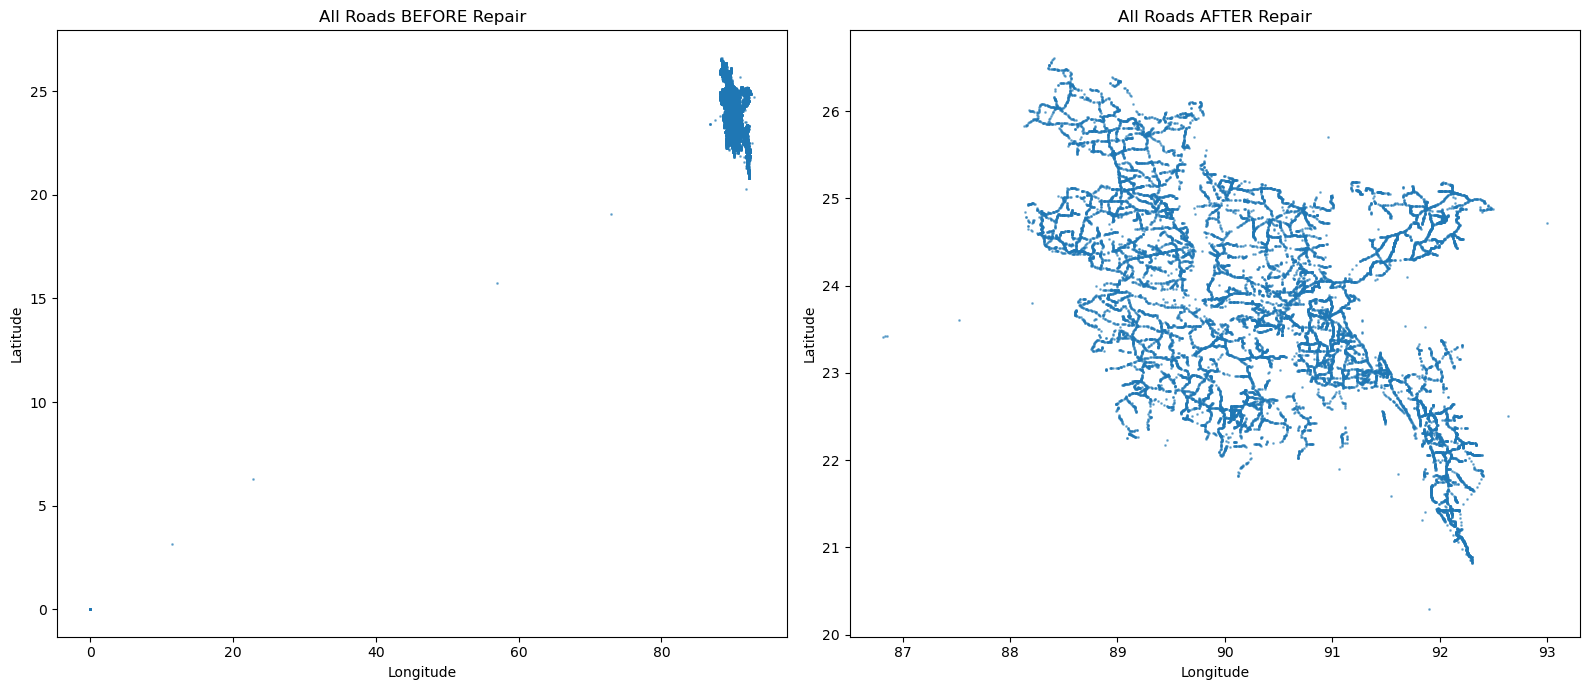

In [53]:
plot_all_roads_before_after(cleaned_tidy,valid_df)

---
# Write output to excel

In [54]:
cleaned_tidy.columns

Index(['road', 'km', 'type', 'lrp', 'name', 'length', 'condition',
       'structureNr', 'roadName', 'chainage', 'width', 'constructionYear',
       'spans', 'zone', 'circle', 'division', 'sub-division', 'lat', 'lon',
       'EstimatedLoc', 'monotone', 'inverted_coords', 'far_out_coords'],
      dtype='object')

In [55]:
#drop unused column and rename previously changed column
output_df = (
    cleaned_tidy
    .drop(columns=["monotone", "inverted_coords", "far_out_coords"])
    .rename(columns={"lrp": "LRPName"})
)

In [56]:
#write to excel file
output_df.to_excel("../data/processed/BMMS_overview.xlsx", index=False)